# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

train = False

import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# script author defined stop words
STOPWORDS_ = ['rt', '', 'httpst', 'amp']

# load the tweets
documents = []
time_seq = []
weeknum = ''
ds_fact = 3
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        if (i % ds_fact == 0):
            index =+ 1
            c_twt = json.loads(l)

            # remove punctuation and stopwords for this analysis
            words = re.sub(r'[^a-zA-Z\s]', '', c_twt['text'])
            words = words.split()
            words = [w for w in words if (w not in STOPWORDS and w not in STOPWORDS_)]
            words = [bytes(w, 'utf-8') for w in words]

            # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
            documents.append(words)

            if weeknum != c_twt['weeknum']:
                time_seq.append(i // ds_fact)
                weeknum = c_twt['weeknum']
            
time_seq.append(len(documents))
y = time_seq[1:] + [0]
x = time_seq[:]
time_seq = []
for x, y in zip(x, y):
    time_seq.append(y - x)

del time_seq[-1]
time_seq

[23389,
 35897,
 95893,
 35265,
 24185,
 8876,
 22790,
 23839,
 24104,
 22814,
 10384,
 44604,
 24929]

In [2]:
from gensim.models import TfidfModel

dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in documents]

len(corpus)

396969

In [3]:
# tfidf = TfidfModel(corpus)
# corpus = tfidf[corpus]
corpus[0]

[(1240, 1), (9118, 1), (14992, 1), (15985, 1), (16811, 1)]

# Train model (or load model from file)

In [4]:
if train:
    dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
    model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                     id2word=dictionary, initialize_lda=True, rng_seed=0)
    model.save('../models/dtm_example.model')
else:
    model = DtmModel.load('../models/doc2vec.model')

In [5]:
topics = model.show_topic(topicid=3, time=11, topn=20)
topics

[(0.025706762315934811, 'aids'),
 (0.02126037062872287, 'drug'),
 (0.015288985148444142, 'gay'),
 (0.013777827750683761, 'prep'),
 (0.012695258382642325, 'man'),
 (0.012519330715254391, 'people'),
 (0.010412911516126295, 'study'),
 (0.0090473222775766249, 'woman'),
 (0.0073848809513324164, 'blood'),
 (0.0072702856165396705, 'key'),
 (0.0068955362940422574, 'says'),
 (0.0063751036730692601, 'africa'),
 (0.0063394514333359056, 'year'),
 (0.0060637242152494115, 'finds'),
 (0.0058736437145957996, 'photos'),
 (0.0056052247061745015, 'medicine'),
 (0.0054937688427263189, 'home'),
 (0.0052633908617332531, 'negative'),
 (0.0051337510064267443, 'treatment'),
 (0.0047664305400190819, 'ex')]

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [31]:
# This cell just gets the week nums (YYYY-WW)

def make_weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week = week + 1

        if week > 53:
            year = year + 1
            week = 1
    
    return weeknums

weeknums = make_weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [26]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=3, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability        Word
0     0.048129       jenny
1     0.047085    mccarthy
2     0.016566        pill
3     0.016078        drug
4     0.012751     prevent
5     0.012399  prevention
6     0.011869      status
7     0.011176         gay
8     0.009970     truvada
9     0.009640      people

--- time slice:  1 

   Probability        Word
0     0.017688        pill
1     0.017497       jenny
2     0.017402        drug
3     0.016490    mccarthy
4     0.013641     prevent
5     0.013558  prevention
6     0.012534      status
7     0.011520         gay
8     0.011034     truvada
9     0.010761        prep

--- time slice:  2 

   Probability        Word
0     0.018445        drug
1     0.017435        pill
2     0.013850  prevention
3     0.013679      status
4     0.013076     prevent
5     0.011979        prep
6     0.011764     truvada
7     0.009553       blood
8     0.009384        aids
9     0.009383      people

--- time slice:  3 

   Probability        

# Figure 1: key terms associated with ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

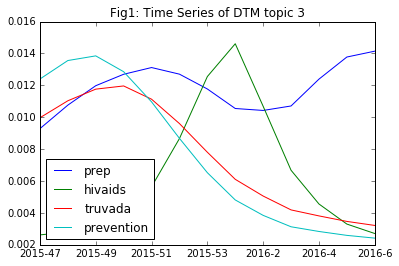

In [69]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['prep', 'hivaids', 'truvada', 'prevention']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig1: Time Series of DTM topic 3')
fig = ax.get_figure()
fig.savefig('Fig1: Time Series of DTM topic 3.pdf', format='pdf')

# Table 2: top 10 words associated with topic ID 8 over time
Note how at time points 2 and 3 we get world AIDS day related words. At time points 7, 8 and 9 the antibiotic 'Zithromax' appears, then disappears. 'gay' also seems to come up during the later time points, which parallels the #egaylity in the Doc2Vec results. 'rt' is not entirely interesting, since it is the name of a news agency.

In [70]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=5, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability             Word
0     0.045626         infected
1     0.037148        infection
2     0.035391           people
3     0.033394     worldaidsday
4     0.026062           living
5     0.024585         millions
6     0.022461             aids
7     0.021590             save
8     0.020112              wad
9     0.019506  treatmentforall

--- time slice:  1 

   Probability             Word
0     0.043330        infection
1     0.040707         infected
2     0.033781           people
3     0.032520     worldaidsday
4     0.024059           living
5     0.022914            signs
6     0.022131         millions
7     0.021241             aids
8     0.020627             save
9     0.020066  treatmentforall

--- time slice:  2 

   Probability             Word
0     0.060310        infection
1     0.037818            signs
2     0.036390         infected
3     0.027458     worldaidsday
4     0.026718           people
5     0.018914           living
6     0

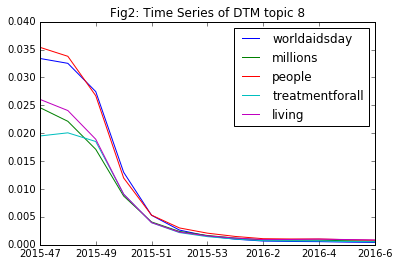

In [71]:
# needs to be re-run. Use tf-idf
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=5, time=t_index, topn=1000)
        
    columns = ['worldaidsday', 'millions', 'people', 'treatmentforall', 'living']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig2: Time Series of DTM topic 8')
fig = ax.get_figure()
fig.savefig('Fig2: Time Series of DTM topic 8.pdf', format='pdf')